# Apriori - Common Contaminants 

PFAS are not just one compound - it encompasses a wide range of chemicals. We want to know which PFAS, specifically, tend to appear together. Do they appear because they're a byproduct of a certain process? Apriori from the package Apyori was used. We tried to use mlxtend's apriori as well, but the runtime was significantly longer than that of apyori.

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
import matplotlib.patches as patches
import geopandas as gpd
from scipy import stats
import seaborn as sns
import re
from IPython.display import display
import zipfile
import io
from apyori import apriori
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori as ap, association_rules 

import geopandas as gpd
import matplotlib.pyplot as plt
import geodatasets
from collections import Counter

First, we loaded the clean data from Github. Since we had to separate the files into 12 csv's for storage reasons, a loop was used to gather and reconstruct the main dataset.

In [3]:
"""Load data"""

# List of file names
files = [f"df{i}.csv" for i in range(1, 13)]
dfs = [pd.read_csv(f'https://github.com/chencheny249/DataMiningProjSpring2025/blob/20232a7cfac86818960cff6e1cae52db708d0bf3/{file}?raw=true', sep=",", encoding="latin1") for file in files]

df = pd.concat(dfs, ignore_index=True)

print(df.shape)

(1499860, 22)


In [4]:
df['Year'].unique()

array([2024, 2023, 2025, 2015, 2014, 2013, 2016], dtype=int64)

In [5]:
df.head()

County                     PWSName Size               FacilityName  \
0  Juneau  CITY AND BOROUGH OF JUNEAU    L  Salmon Creek Reservoir TP   
1  Juneau  CITY AND BOROUGH OF JUNEAU    L  Salmon Creek Reservoir TP   
2  Juneau  CITY AND BOROUGH OF JUNEAU    L  Salmon Creek Reservoir TP   
3  Juneau  CITY AND BOROUGH OF JUNEAU    L  Salmon Creek Reservoir TP   
4  Juneau  CITY AND BOROUGH OF JUNEAU    L  Salmon Creek Reservoir TP   

  FacilityWaterType     SamplePointName CollectionDate     SampleID  \
0                SW  Salmon Creek DS EP     2024-11-04  32403661003   
1                SW  Salmon Creek DS EP     2024-11-04  32403661003   
2                SW  Salmon Creek DS EP     2024-11-04  32403661003   
3                SW  Salmon Creek DS EP     2024-11-04  32403661003   
4                SW  Salmon Creek DS EP     2024-11-04  32403661003   

  Contaminant  Region  ... Month  MRL_Exceeded  MRL_Not_Exceeded  \
0        PFNA      10  ...    11             0                 1   
1       PFUnA      10  ...    11             0                 1   
2    NEtFOSAA      10  ...    11             0                 1   
3       PFHpS      10  ...    11             0                 1   
4  9Cl-PF3ONS      10  ...    11             0                 1   

   Relative_MRL  MCL_Exceeded  MCL_Not_Exceeded  Relative_MCL  Median_Income  \
0           0.0             0                 1           0.0            NaN   
1           0.0             0                 1           0.0            NaN   
2           0.0             0                 1           0.0            NaN   
3           0.0             0                 1           0.0            NaN   
4           0.0             0                 1           0.0            NaN   

   Child_Poverty_Rate  Poverty_Rate  
0                 NaN           NaN  
1                 NaN           NaN  
2                 NaN           NaN  
3                 NaN           NaN  
4                 NaN           NaN  

[5 rows x 22 columns]

In [6]:
df.columns

Index(['County', 'PWSName', 'Size', 'FacilityName', 'FacilityWaterType',
       'SamplePointName', 'CollectionDate', 'SampleID', 'Contaminant',
       'Region', 'State', 'Year', 'Month', 'MRL_Exceeded', 'MRL_Not_Exceeded',
       'Relative_MRL', 'MCL_Exceeded', 'MCL_Not_Exceeded', 'Relative_MCL',
       'Median_Income', 'Child_Poverty_Rate', 'Poverty_Rate'],
      dtype='object')

For reference, below are the types of PFAS found in our water systems per the EPA. 

In [7]:
print(df['Contaminant'].unique())

['PFNA' 'PFUnA' 'NEtFOSAA' 'PFHpS' '9Cl-PF3ONS' '11Cl-PF3OUdS' 'PFPeA'
 'PFBS' 'PFHxS' 'HFPO-DA' 'PFEESA' 'PFTrDA' 'NMeFOSAA' 'PFTA' 'PFMBA'
 'PFMPA' '8:2 FTS' 'PFHpA' 'NFDHA' 'PFHxA' '4:2 FTS' 'PFOA' '6:2 FTS'
 'PFOS' 'PFPeS' 'ADONA' 'PFBA' 'PFDA' 'PFDoA']


Not only do we want to know which contaminants appear together more often, more specifically we want to know which contaminants that exceed their MCL appear more often. Quite frankly, a lot of these PFAS chemicals are so widespread at this point that looking through the entire dataset would not only take a long time, but wouldn't provide that much useful information. A new dataframe was therefore made containing only contaminants that exceeded their MCL as those are more of concern and high priority for remediation.

In [8]:
#make new dataframe of samples where the MCL has been exceeded
df_exceed=df[df['MCL_Exceeded']==1]

## Common Contaminants by Sample

First we looked at each sample to see if there were any common contaminants. The dataset was converted to a list of "transactions" where each row or transaction is a sample and the items are the different contaminants. 

In [9]:
#Create list of contaminants by samples
transactions_samples=df_exceed.groupby("SamplePointName")["Contaminant"].apply(list).tolist()

In [10]:
# Get items through apriori and convert to a list
sample_items = apriori(transactions_samples, 
                          min_support=0.15,  
                          min_confidence=0.15,  
                          min_lift=1)
result = list(sample_items)


In [11]:
#Convert results to an array and then a dataframe for easier viewing
sample_arr=[]
#for each itemset
for itemset in result:
  # extract the item name, support, confidence, and lift values
  for ordered_stat in itemset.ordered_statistics:
    sample_arr.append({'itemsets': list(itemset.items),
               'support': itemset.support,
              'confidence': ordered_stat.confidence,
               'lift':ordered_stat.lift})

#convert the intermediate array to a dataframe
samples=pd.DataFrame(sample_arr)
 
#get rid of duplicates
samples.drop_duplicates('itemsets',inplace=True)


In [12]:
#filter for 3-itemsets
samples_3=samples[samples['itemsets'].apply(lambda x:len(x)==3)]
samples_3

itemsets   support  confidence  lift
49  [PFPeA, PFBA, PFHxA]  0.199803    0.199803   1.0
56  [PFBS, PFPeA, PFHxA]  0.184029    0.184029   1.0
63   [PFOA, PFOS, PFHxA]  0.154124    0.154124   1.0
70  [PFOA, PFPeA, PFHxA]  0.188958    0.188958   1.0
77  [PFOS, PFPeA, PFHxA]  0.172198    0.172198   1.0
84   [PFOA, PFOS, PFPeA]  0.166283    0.166283   1.0

In [13]:
#Sort by support
samples_3=samples_3.sort_values(by="support",ascending=False)
samples_3

itemsets   support  confidence  lift
49  [PFPeA, PFBA, PFHxA]  0.199803    0.199803   1.0
70  [PFOA, PFPeA, PFHxA]  0.188958    0.188958   1.0
56  [PFBS, PFPeA, PFHxA]  0.184029    0.184029   1.0
77  [PFOS, PFPeA, PFHxA]  0.172198    0.172198   1.0
84   [PFOA, PFOS, PFPeA]  0.166283    0.166283   1.0
63   [PFOA, PFOS, PFHxA]  0.154124    0.154124   1.0

In [14]:
all_contaminants_in_3 = [item for itemset in samples_3['itemsets'] for item in itemset]

# Get unique contaminants
unique_contaminants = set(all_contaminants_in_3)
print("Total list of unique contaminants in 3-itemsets:")
print(unique_contaminants)

Total list of unique contaminants in 3-itemsets:
{'PFOA', 'PFBA', 'PFOS', 'PFBS', 'PFPeA', 'PFHxA'}


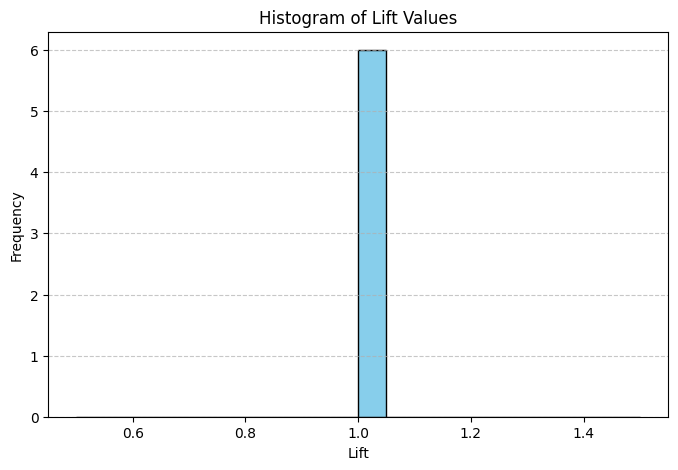

In [37]:
plt.figure(figsize=(8, 5))
plt.hist(samples_3['lift'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Out of the 29 PFAS in the dataset, these 6 appear the most in water samples taken across the country and were also exceeding their Maximum Contamination Level. 

PFHxS, or perfluorohexanesulphonic acid is used in surfactants, protective coatings, and metal plating agents. While its production is on the decline, it can also result from PFOS production or from the degradation of other PFAS chemicals.

PFBA (perfluorobutanoic acid) and PFBS (perfluorobutane sulfonate) also have typical PFAS properties such as being used in nonstick and stain resistant products, firefighting foam, photographic film, etc. They are also a breakdown product of other PFAS.Like PFHxS, PFBA's production is on the decline but it certainly lives up to its name of a forever chemical. PFBS is still being produced by 3M as a safer alternative to PFOS. (https://www.health.state.mn.us/communities/environment/risk/docs/guidance/gw/pfbainfo.pdf) https://www.health.state.mn.us/communities/environment/risk/docs/guidance/gw/pfbsinfo.pdf 

PFPeA is perfluoropentanoic acid. PFHpA, PFHxA, PFBS, and PFPeA are labeled as "safer" alternatives to other PFAS like PFOA and PFOS. However, these short chain PFAS still induced adverse effects in mice. (https://data.cdc.gov/National-Institute-for-Occupational-Safety-and-Hea/Systemic-toxicity-induced-by-topical-application-o/x7xw-nitb/about_data)

PFOA and PFOS are long (C8) PFAS and are the "traditional" PFAS that have been linked to numerous health and environmental issues.

It seems that overall, the "safer" short chain PFAS appear together more often. With that said, the C8s like PFOA and PFOS are still appearing together along with chemicals that are a byproduct or a degradation of the C8s, which makes sense. It is concerning that the C8s are exceeding their MCL enough to be in these itemsets, especially as they're allegedly more toxic.

Interestingly, the lift for all of these itemsets are 1, which means that there's no association between these contaminants that wouldn't occur by chance.

## Common Contaminants by Facility

We then looked at the common contaminant sets by facilities. A similar process as the samples was performed. The 'transactions' of contaminants was set for the scope, apriori was run, and then the results are shown below.

In [15]:
#transactions by facilities
transactions_facilities=df_exceed.groupby("FacilityName")["Contaminant"].apply(list).tolist()

In [16]:
#get items by facility
facilities_items = apriori(transactions_facilities, 
                          min_support=0.1,  
                          min_confidence=0.1,  
                          min_lift=2)
resultfac = list(facilities_items)

In [43]:
#Convert results of apriori() to an array and then a dataframe for easier viewing
fac_arr=[]
#for each itemset
for itemset in resultfac:
  # extract the item name, support, confidence, and lift values
  for ordered_stat in itemset.ordered_statistics:
    fac_arr.append({'itemsets': list(itemset.items),
               'support': itemset.support,
              'confidence': ordered_stat.confidence,
               'lift':ordered_stat.lift})

#convert the intermediate array to a dataframe
fac_df=pd.DataFrame(fac_arr)


#get rid of duplicates
fac_df.drop_duplicates('itemsets',inplace=True)

#filter for only 3-itemsets
fac3=fac_df[fac_df['itemsets'].apply(lambda x:len(x)==4)]

#sort by lift
fac3=fac3.sort_values(by="lift",ascending=False)
fac3

itemsets   support  confidence      lift
176  [PFHxS, PFOS, PFPeA, PFHxA]  0.101181    0.271028  2.543704
70    [PFBS, PFPeA, PFBA, PFHxA]  0.139560    0.373832  2.537153
104   [PFOA, PFPeA, PFBA, PFHxA]  0.132045    0.353702  2.519876
114   [PFOS, PFPeA, PFBA, PFHxA]  0.122383    0.327822  2.487706
60     [PFBS, PFOS, PFBA, PFHxA]  0.101449    0.308824  2.437874
50     [PFBS, PFOA, PFBA, PFHxA]  0.107622    0.327614  2.398214
186   [PFOA, PFOS, PFPeA, PFHxA]  0.168009    0.450036  2.388652
90     [PFBS, PFOS, PFBA, PFPeA]  0.103060    0.313725  2.380736
98     [PFOA, PFOS, PFBA, PFHxA]  0.107085    0.286844  2.364559
80     [PFBS, PFOA, PFBA, PFPeA]  0.107622    0.327614  2.334018
130    [PFBS, PFOA, PFOS, PFHxA]  0.134192    0.408497  2.327307
166    [PFBS, PFOA, PFOS, PFPeA]  0.140097    0.426471  2.263575
154   [PFBS, PFOS, PFPeA, PFHxA]  0.143586    0.437092  2.249452
142   [PFBS, PFOA, PFPeA, PFHxA]  0.151637    0.461601  2.087289
124    [PFOA, PFOS, PFBA, PFPeA]  0.108964    0.247109  2.037009

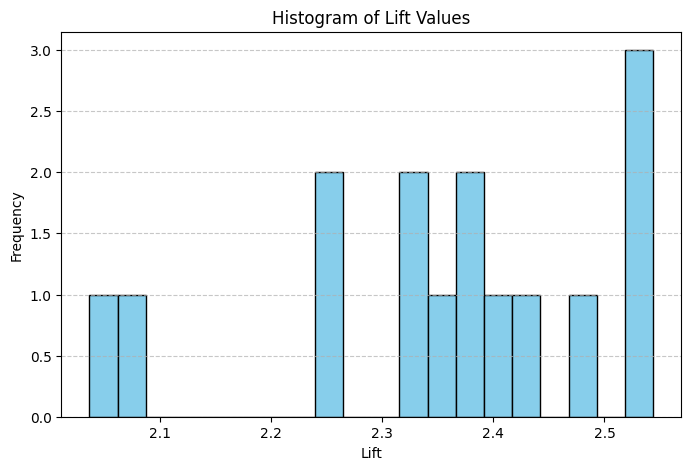

In [ ]:
# lift histogram
plt.figure(figsize=(8, 5))
plt.hist(fac3['lift'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Based on the results here, it seems that the lift for these itemsets are quite high (over 2) which means that they are strongly associated - these contaminants are twice as likely to occur together than by sheer chance. There are a total of 15 itemsets, with 3 sets having lifts over 2.5. They also have a fairly high support value for such a large dataset/large number of facilities. The confidence values are solidly between 25-50%, which for 4-itemsets and the large amounts of PFAS there are, are pretty good. Unfortunately, because there are so many facilities across the US, finding which facilities match these itemsets isn't very helpful. The results below show the sheer number of facilities and often how not descriptive they are. That's why we then looked at the county level.

In [18]:
#Create a lookup table of contaminant sets by facility
fac_contaminants = df.groupby('FacilityName')['Contaminant'].apply(set).reset_index()

#Find matching states for the itemsets
for idx, row in fac3.iterrows():
    itemset=set(row['itemsets'])
    matching_cnty = fac_contaminants[
        fac_contaminants['Contaminant'].apply(lambda x: itemset.issubset(x))]['FacilityName'].tolist()
    print(f"{row['itemsets']} found in facilities: {matching_cnty}")

['PFHxS', 'PFOS', 'PFPeA', 'PFHxA'] found in facilities: ['#1 HYDRANT', '#2 HYDRANT', '#2 well', '#3 WELL', '#3 well', '#33/#47 WELL', '#34 WELL', '#39 WELL', '#4 well', '#48 WELL', '#49 WELL', '#5 well', '#6 well', '017', '10', '10 - 90 Well', '10 MG Storage Tank', '100', '100 East Well', '1000 S. 600 E. Well', '1000 Simpson Terrace', '100K Storage Tank', '1014 N BATTLEBELL RD HIGHLANDS', '104 W 9th St', '1050 Trimble Ln/Plant 4/Well 5', '1094 Elizabeth Ave.(Landa GST)', '10th Street Plant', '10th Street Well', '1100 N. 100 E. Well', '1100 N. Central (Headwaters Tank)', '1101 H.O. Mills', '1105 Carl Stern', '1110 North Main', '1114 N. Chenango St, Angleton', '112th & Deepwood Q-1', '1150 TRIMBLE LN/ PLANT5/WELL 6', '1186 N. Walnut Ave (Grandview GST)', '120 Green Rd Tank', '1201 Clear Valley Dr WP1', '123 PCE Blend (123-1 & 123-2)', '127th Lane Well', '129th St. Well 2 Plant', '12th St. Chlorination Station', '12th St. Wellfield', '1318 Pike Fort Bliss', '132-1 Blend (w/133, 135 & 138

## Common Contaminants by County

The same process for data processing and apriori as before was done.

In [19]:
# Find similarities among states
transactions_county=df_exceed.groupby("County")["Contaminant"].apply(list).tolist()

In [45]:
# Testing with Apyori's apriori for proof of concept

county_items = apriori(transactions_county, 
                          min_support=0.11,  
                          min_confidence=0.1,  
                          min_lift=2)
result = list(county_items)

#Convert results of apriori() to an array and then a dataframe for easier viewing
county_arr=[]
#for each itemset
for itemset in result:
  #print(itemset)
  # extract the item name, support, confidence, and lift values
  for ordered_stat in itemset.ordered_statistics:
    #print(ordered_stat)
    county_arr.append({'itemsets': list(itemset.items),
               'support': itemset.support,
              'confidence': ordered_stat.confidence,
               'lift':ordered_stat.lift})

#convert the intermediate array to a dataframe
counties=pd.DataFrame(county_arr)

#filter for only 3-itemsets
counties=counties[counties['itemsets'].apply(lambda x:len(x)==3)]

#get rid of duplicates
counties.drop_duplicates('itemsets',inplace=True)

counties=counties.sort_values(by="support",ascending=False)
counties



itemsets   support  confidence      lift
44  [PFHpA, PFPeA, PFHxA]  0.198872    0.411079  2.023992
38   [PFHpA, PFOA, PFHxA]  0.196051    0.891026  2.458121
60   [PFHpA, PFOA, PFPeA]  0.193230    0.878205  2.323311
56    [PFHpA, PFOA, PFOS]  0.190409    0.865385  2.207042
2    [PFHpA, PFBA, PFHxA]  0.188999    0.858974  2.198602
42   [PFHpA, PFOS, PFHxA]  0.188999    0.858974  2.315638
62   [PFHpA, PFOS, PFPeA]  0.187588    0.852564  2.174345
8     [PFHpA, PFOA, PFBA]  0.187588    0.852564  2.379795
14   [PFHpA, PFBA, PFPeA]  0.186178    0.846154  2.013165
30   [PFBS, PFHpA, PFPeA]  0.184767    0.839744  2.096402
16   [PFBS, PFHpA, PFHxA]  0.184767    0.839744  2.229881
12    [PFHpA, PFOS, PFBA]  0.183357    0.833333  2.196406
28    [PFBS, PFOS, PFHpA]  0.181946    0.826923  2.204092
24    [PFBS, PFOA, PFHpA]  0.180536    0.820513  2.246114
0     [PFBS, PFHpA, PFBA]  0.177715    0.807692  2.169143
32  [PFHpA, PFHxS, PFHxA]  0.163611    0.743590  2.522513
52  [PFHpA, PFHxS, PFPeA]  0.163611    0.743590  2.429517
46   [PFHpA, PFHxS, PFOA]  0.157969    0.717949  2.597070
48   [PFHpA, PFHxS, PFOS]  0.156559    0.711538  2.222382
20   [PFBS, PFHxS, PFHpA]  0.155148    0.705128  2.380647
4    [PFHpA, PFHxS, PFBA]  0.155148    0.705128  2.499679

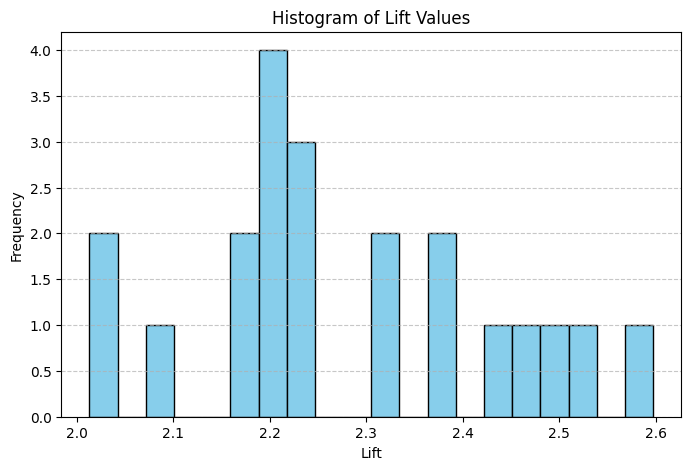

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(counties['lift'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

There are 21 3-itemsets, all with lifts above 2, which is quite high - these contaminants are very positively associated. The confidence here is even higher than that of the facility level, and the support value is still respectable for how big the dataset is. These associations make sense, as they are comprised of long chain PFAS and their short chain derivatives and substitutes.

At the county level, we wanted to map out the results for better visualization, so we brought in geospatial data.

In [21]:
#US county data
df_counties = pd.read_csv('https://github.com/chencheny249/DataMiningProjSpring2025/blob/20232a7cfac86818960cff6e1cae52db708d0bf3/uscounties.csv?raw=true', sep=",", encoding="latin1")
df_counties=df_counties.rename(columns={'county_full':'County'})
df_counties.head()

county county_ascii              County  county_fips state_id  \
0  Los Angeles  Los Angeles  Los Angeles County         6037       CA   
1         Cook         Cook         Cook County        17031       IL   
2       Harris       Harris       Harris County        48201       TX   
3     Maricopa     Maricopa     Maricopa County         4013       AZ   
4    San Diego    San Diego    San Diego County         6073       CA   

   state_name      lat       lng  population  
0  California  34.3219 -118.2247     9848406  
1    Illinois  41.8401  -87.8168     5185812  
2       Texas  29.8578  -95.3938     4758579  
3     Arizona  33.3490 -112.4915     4491987  
4  California  33.0343 -116.7350     3282782

In [22]:
# Create a lookup table of contaminant sets by facility
county_contaminants = df.groupby('County')['Contaminant'].apply(set).reset_index()

matching_cnty_tot=[]
# For each rule in rules_state_3, find matching states
for idx, row in counties.iterrows():
    itemset=set(row['itemsets'])
    matching_cnty = county_contaminants[
        county_contaminants['Contaminant'].apply(lambda x: itemset.issubset(x))]['County'].tolist()
    matching_cnty_tot.append(matching_cnty)
    print(f"{row['itemsets']} found in counties: {matching_cnty}")

['PFHpA', 'PFPeA', 'PFHxA'] found in counties: ['Abbeville County', 'Acadia Parish', 'Accomack County', 'Ada County', 'Adair County', 'Adams County', 'Addison County', 'Aiken County', 'Alachua County', 'Alamance County', 'Alameda County', 'Alamosa County', 'Albany County', 'Albemarle County', 'Alcorn County', 'Aleutians West Census Area', 'Alexander County', 'Alfalfa County', 'Allegan County', 'Allegany County', 'Alleghany County', 'Allegheny County', 'Allen County', 'Allen Parish', 'Alpena County', 'Alpine County', 'Amador County', 'Amherst County', 'Anchorage Municipality', 'Anderson County', 'Andrew County', 'Androscoggin County', 'Angelina County', 'Anne Arundel County', 'Anoka County', 'Anson County', 'Antrim County', 'Apache County', 'Appanoose County', 'Appling County', 'Aransas County', 'Arapahoe County', 'Archuleta County', 'Arenac County', 'Arkansas County', 'Arlington County', 'Armstrong County', 'Aroostook County', 'Ascension Parish', 'Ashland County', 'Ashley County', 'Ash

In [23]:
#flatten counties for getting counts
flattened_counties = [county for sublist in matching_cnty_tot for county in sublist]
# Count frequency
county_counts = Counter(flattened_counties)
cnty_freq_df = pd.DataFrame(county_counts.items(), columns=['County', 'count'])
cnty_freq_df.head()



County  count
0  Abbeville County     21
1     Acadia Parish     21
2   Accomack County     21
3        Ada County     21
4      Adair County     21

        county county_ascii              County  county_fips state_id  \
0  Los Angeles  Los Angeles  Los Angeles County         6037       CA   
1         Cook         Cook         Cook County        17031       IL   
2       Harris       Harris       Harris County        48201       TX   
3     Maricopa     Maricopa     Maricopa County         4013       AZ   
4    San Diego    San Diego    San Diego County         6073       CA   

   state_name      lat       lng  population  count  
0  California  34.3219 -118.2247     9848406   21.0  
1    Illinois  41.8401  -87.8168     5185812   21.0  
2       Texas  29.8578  -95.3938     4758579   21.0  
3     Arizona  33.3490 -112.4915     4491987   21.0  
4  California  33.0343 -116.7350     3282782   21.0  


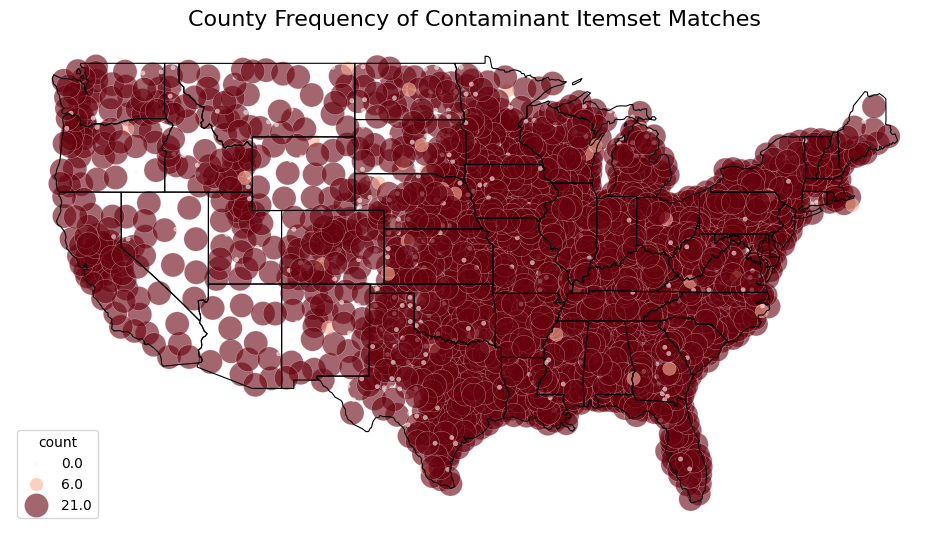

In [24]:
# Merge
county_map = df_counties.merge(cnty_freq_df, on='County', how='left')

# Fill NaN counts with 0 for counties not in any itemset
county_map['count'] = county_map['count'].fillna(0)

print(county_map.head())

# Load US states borders
url = "https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json"
usa = gpd.read_file(url)

#continental US only for this analysis
usa_continental = usa[~usa["name"].isin(["Hawaii", "Puerto Rico", "District of Columbia", "Alaska"])]  # Filter out non-continental states
county_map = county_map[~county_map["state_name"].isin(["Hawaii", "Puerto Rico", "District of Columbia", "Alaska"])]

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot state boundaries
usa_continental.boundary.plot(ax=ax, linewidth=0.8, color="black")
# Plotting counties
sns.scatterplot(
    data=county_map,
    x='lng',
    y='lat',
    size='count',
    hue='count',
    sizes=(10, 300),
    palette='Reds',
    alpha=0.6,
    ax=ax
)
plt.title('County Frequency of Contaminant Itemset Matches', fontsize=16)
plt.axis('off')
plt.show()


This map shows counties that have the most common sets of contaminants exceeding their MCL, and the contamination is widespread. The main spots that don't have the common contaminant occurances are in the sparsely populated, dry desert area of the country (western Montana, Nevada, etc.). Some counties in the Southeast and Midatlantic have less of the itemsets, which is interesting. However, that doesn't mean that the water there isn't contaminated - the waterways could have other PFAS as well that wasn't picked up by the Apriori model.

We also ran a state model to see how the results would change on an even bigger scale.

## Common Contaminants by State

In [25]:
# Find similarities among states
transactions_state=df_exceed.groupby("State")["Contaminant"].apply(list).tolist()

In [26]:
# State level Apriori

state_items = apriori(transactions_state, 
                          min_support=0.8,  
                          min_confidence=0.8,  
                          min_lift=1.1)
result = list(state_items)

#Convert results of apriori() to an array and then a dataframe for easier viewing
state_arr=[]
#for each itemset
for itemset in result:
  # extract the item name, support, confidence, and lift values
  for ordered_stat in itemset.ordered_statistics:
    state_arr.append({'itemsets': list(itemset.items),
               'support': itemset.support,
              'confidence': ordered_stat.confidence,
               'lift':ordered_stat.lift})

#convert the intermediate array to a dataframe
states=pd.DataFrame(state_arr)

#filter for only 4-itemsets
states4=states[states['itemsets'].apply(lambda x:len(x)==4)]

#get rid of duplicates
states4.drop_duplicates('itemsets',inplace=True)

states4=states4.sort_values(by="lift",ascending=False)
states4


C:\Users\chenc\AppData\Local\Temp\ipykernel_9680\332851457.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states4.drop_duplicates('itemsets',inplace=True)


itemsets   support  confidence      lift
78   [PFBS, PFHxS, PFPeA, PFHxA]  0.816327    0.975610  1.195122
116   [PFHxS, PFOS, PFOA, PFHxA]  0.816327    0.975610  1.195122
128  [PFHxS, PFPeA, PFOA, PFHxA]  0.816327    0.975610  1.195122
142  [PFHxS, PFOS, PFPeA, PFHxA]  0.836735    1.000000  1.195122
68    [PFBS, PFHxS, PFOS, PFHxA]  0.816327    0.975610  1.165973
90    [PFBS, PFOS, PFPeA, PFHxA]  0.816327    0.975610  1.165973
154   [PFOA, PFOS, PFPeA, PFHxA]  0.816327    0.975610  1.165973
106    [PFBS, PFOA, PFOS, PFPeA]  0.816327    0.952381  1.138211
166   [PFHxS, PFOS, PFOA, PFPeA]  0.816327    0.952381  1.138211
100   [PFBS, PFHxS, PFOS, PFPeA]  0.816327    0.930233  1.111741

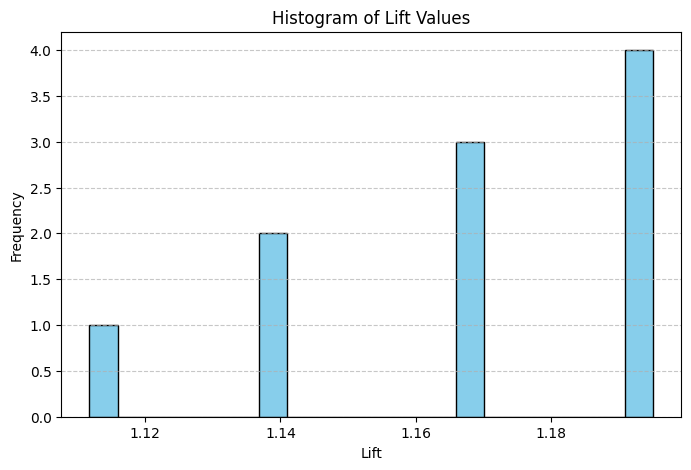

In [41]:
plt.figure(figsize=(8, 5))
plt.hist(states4['lift'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Lift Values')
plt.xlabel('Lift')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We looked at 4-itemsets here to avoid seeing the same few contaminants in different permutations. There are 10 4-itemsets here, all with lifts or association values that are positive, but not as high as that of the county level or facility level model. The support and confidence levels are higher though. This might be because statewide data has more noise, and county/facility level analyses have more specific patterns that the model picked up on. For the state level, we're lumping together a lot of data that might behave differently when looked at under the microscope. This is a typical Modifiable Area Unit Problem in mapping where how you set your boundaries/control areas affects your results.

In [27]:
#filter for only 5-itemsets
states5=states[states['itemsets'].apply(lambda x:len(x)==5)]

#get rid of duplicates
states5.drop_duplicates('itemsets',inplace=True)

states5=states5.sort_values(by="lift",ascending=False)
states5

C:\Users\chenc\AppData\Local\Temp\ipykernel_9680\296093112.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states5.drop_duplicates('itemsets',inplace=True)


itemsets   support  confidence      lift
174  [PFHxS, PFOS, PFHxA, PFBS, PFPeA]  0.816327     0.97561  1.195122
200  [PFOA, PFHxS, PFOS, PFHxA, PFPeA]  0.816327     0.97561  1.195122

Based on this apriori model, it seems that (PFHxS, PFHxA, PFBS, PFPeA) and many combinations of those are more likely to appear together than if they were independent, as their lift values are all greater than 1. If we were to look at 5-itemsets to reduce looking at various permutations of the same itemsets, it seems that PFHxS, PFPeA, PFHxA, and PFOS all tend to occur together - the only two that aren't appearing together as much are PFBS and PFOA in a 5-itemset. PFBS and PFOA do occur together in various permutations in 4-itemsets, however. These 6 contaminants seem to be the main PFAS that contaminate our water. We then mapped these itemsets back to the states that have them and plotted the results. All of these contaminants are either byproducts of one another, are currently produced, or were very popular when PFAS were first introduced, so these combinations make sense.

In [28]:
# Ensure the State contaminant sets are correctly prepared
state_contaminants = df_exceed.groupby('State')['Contaminant'].apply(set).reset_index()

matching_states_tot=[]
# Iterate through each rule (itemset) in rules_state_3
for idx, row in states4.iterrows():
    itemset = set(row['itemsets'])  # Convert itemsets to set

    # Check if the itemset is a subset of any state's contaminant set
    matching_states = state_contaminants[
        state_contaminants['Contaminant'].apply(lambda x: itemset.issubset(x))]['State'].tolist()
    matching_states_tot.append(matching_states)
    # Output the results
    print(f"Itemset {row['itemsets']} found in states: {matching_states}")


flattened_states = [state for sublist in matching_states_tot for state in sublist]


Itemset ['PFBS', 'PFHxS', 'PFPeA', 'PFHxA'] found in states: ['AL', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV', 'WY']
Itemset ['PFHxS', 'PFOS', 'PFOA', 'PFHxA'] found in states: ['AK', 'AL', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV']
Itemset ['PFHxS', 'PFPeA', 'PFOA', 'PFHxA'] found in states: ['AK', 'AL', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'NC', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI', 'WV']
Itemset ['PFHxS', 'PFOS', 'PFPeA', 'PFHxA'] found in states: ['AK', 'AL', 'AZ', 'CA', 'CO', 'CT

We chose to map the state apriori model results as well. 

In [29]:
# Count frequency
state_counts = Counter(flattened_states)

# Convert to DataFrame
state_freq_df = pd.DataFrame(state_counts.items(), columns=['state_name', 'count'])
state_abbreviations = pd.DataFrame({
    'state_long': ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
              'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
              'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
              'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
              'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
    'state_name': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
                     'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
                     'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                     'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
                     'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
})

#cleaning
usa_continental=usa_continental.rename(columns={'name':'state_long'})
usa_continental = usa_continental.merge(state_abbreviations, on='state_long', how='left')
usa_continental.drop(['state_long','id','density'],axis=1,inplace=True)
usa_continental.head()

geometry state_name
0  POLYGON ((-87.3593 35.00118, -85.60668 34.9847...         AL
1  POLYGON ((-109.0425 37.00026, -109.04798 31.33...         AZ
2  POLYGON ((-94.47384 36.50186, -90.15254 36.496...         AR
3  POLYGON ((-123.23326 42.00619, -122.37885 42.0...         CA
4  POLYGON ((-107.91973 41.00391, -105.72895 40.9...         CO

                                            geometry state_name  count
0  POLYGON ((-87.3593 35.00118, -85.60668 34.9847...         AL   10.0
1  POLYGON ((-109.0425 37.00026, -109.04798 31.33...         AZ   10.0
2  POLYGON ((-94.47384 36.50186, -90.15254 36.496...         AR    0.0
3  POLYGON ((-123.23326 42.00619, -122.37885 42.0...         CA   10.0
4  POLYGON ((-107.91973 41.00391, -105.72895 40.9...         CO   10.0


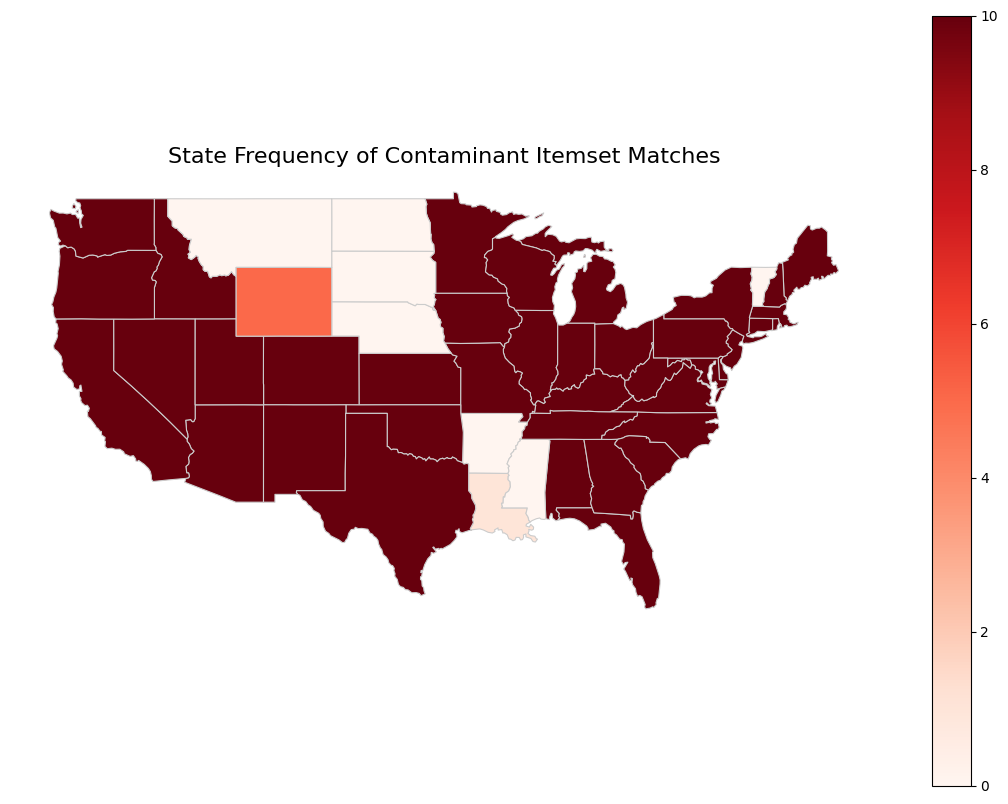

In [30]:
# Merge
map_df = usa_continental.merge(state_freq_df, on='state_name', how='left')

# Fill NaN counts with 0 for states not in any itemset
map_df['count'] = map_df['count'].fillna(0)

print(map_df.head())

#plot
fig, ax = plt.subplots(figsize=(14, 10))
map_df.plot(column='count',
            cmap='Reds',
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend=True)

plt.title('State Frequency of Contaminant Itemset Matches', fontsize=16)
plt.axis('off')
plt.show()

This state-level map shows that the most common PFAS contaminant combinations that tend to be found together (and are exceeding their MCLs) are occuring basically throughout the continental United States, which more or less matches the county map. However, while the county map shows that some counties in Wyoming, Montana, Louisiana, etc. still have these itemsets, the state level map shows that Wyoming and Louisiana barely have any, and Montana, Nebraska, Arkansas, Mississippi, North Dakota, and South Dakota do not have these combinations at all. Again, that doesn't mean they don't have PFAS, but they just don't have these 4-contaminant combinations that occur together. Wyoming, Nebraska, Montana, and the Dakotas are states with relatively low populations, so perhaps that has impacted the PFAS in their water. There may be less manufacturing, or slightly different water sampling methodology. 

Louisiana had unexpected results since there are a lot of oil and chemical plants. We would've expected LA to also have those sets of contaminants. Similarly, we did not expect Arksansas and Mississippi to not have any of those sets either. These three states have industry, have a lot of shared waterways, and are near the Mississippi River in a location that is downstream for all the other states that the river goes through. Even if they don't produce those PFAS chemicals specifically, we expected that runoff would bring the contaminants there anyways. We checked the dataset to see if the dataset was imbalanced.

In [31]:
df_exceed[df_exceed['State']=='AR'].shape

(10, 22)

In [32]:
df_exceed[df_exceed['State']=='LA'].shape

(102, 22)

In [33]:
df_exceed[df_exceed['State']=='CO'].shape

(475, 22)

Colorado, a state with all the combinations of the contaminants, did have more samples that exceeded the MCL than Arkansas and Louisiana, for example. However, when checking the total number of occurances for those states, Louisiana had even more samples than Colorado - they just had less that were above the MCL. 

In [34]:
df[df['State']=='CO'].shape

(23752, 22)

In [35]:
df[df['State']=='LA'].shape

(29427, 22)

In [36]:
df[df['State']=='AR'].shape

(13365, 22)

Some potential reasons for this might be that the PFAS that do occur in states like Louisiana, Montana, etc. are not the popular co-occuring ones that we found. There are a lot of other more obscure PFAS compounds that are in the dataset. Another reason is that there can also be differences in sampling methodology between states over the years. The EPA seems to only sample every decade or so, and a lot can and has changed over time in environmental policy and protection. 

The main takeaway from this analysis is how widespread the long chain PFOA/PFOS and their derivatives are. Even when they degrade, they still exist in the water system in different forms. The county vs state level maps show that the state level map perhaps generalized the contamination patterns too much, because there is still contamination in all those counties, but when clumped together, that contamination pattern gets diluted.

The best model here would be the county level model as it more accuratelly portrays the association of the contaminants and is detailed enough to show differences within a state while not getting too into the weeds (like with the facility level model).